<a href="https://colab.research.google.com/github/dsogden/NLP-Specialization/blob/main/AG_News_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)
print(device)

cpu


In [101]:
path = '/content/drive/MyDrive/0000.parquet'
df = pd.read_parquet(path)
df.head(10)

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
5,"Stocks End Up, But Near Year Lows (Reuters) Re...",2
6,Money Funds Fell in Latest Week (AP) AP - Asse...,2
7,Fed minutes show dissent over inflation (USATO...,2
8,Safety Net (Forbes.com) Forbes.com - After ear...,2
9,Wall St. Bears Claw Back Into the Black NEW Y...,2


In [102]:
import nltk
from nltk.tokenize import word_tokenize
import string
import re

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [103]:
def text_lowercase(text):
    return text.lower()

def remove_url(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text)

def remove_com(text):
    return text.replace('.com', '')

def remove_slashes(text):
    return text.replace('\\', ' ').replace('-', ' ')

def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

def remove_whitespace(text):
    return text.replace('  ', ' ')

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [
        word for word in word_tokens
        if (word not in stop_words) and (word not in string.punctuation)
    ]
    return filtered_text

In [157]:
def pipeline(text):
    lower = text_lowercase(text)
    url = remove_url(lower)
    com = remove_com(url)
    slashes = remove_slashes(com)
    numbers = remove_numbers(slashes)
    whitespace = remove_whitespace(numbers)
    filtered = remove_stopwords(whitespace)
    return filtered

output = [pipeline(text) for text in df.text]
max_length = max(len(tokens) for tokens in output)
print(max_length, output[:10])

168 [['wall', 'st.', 'bears', 'claw', 'back', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', "'s", 'dwindling', 'band', 'ultra', 'cynics', 'seeing', 'green'], ['carlyle', 'looks', 'toward', 'commercial', 'aerospace', 'reuters', 'reuters', 'private', 'investment', 'firm', 'carlyle', 'group', 'reputation', 'making', 'well', 'timed', 'occasionally', 'controversial', 'plays', 'defense', 'industry', 'quietly', 'placed', 'bets', 'another', 'part', 'market'], ['oil', 'economy', 'cloud', 'stocks', 'outlook', 'reuters', 'reuters', 'soaring', 'crude', 'prices', 'plus', 'worries', 'economy', 'outlook', 'earnings', 'expected', 'hang', 'stock', 'market', 'next', 'week', 'depth', 'summer', 'doldrums'], ['iraq', 'halts', 'oil', 'exports', 'main', 'southern', 'pipeline', 'reuters', 'reuters', 'authorities', 'halted', 'oil', 'export', 'flows', 'main', 'pipeline', 'southern', 'iraq', 'intelligence', 'showed', 'rebel', 'militia', 'could', 'strike', 'infrastructure', 'oil', 'official

In [158]:
def build(tokens, max_length):
    vocab = set(word for line in tokens for word in line)
    N = len(tokens)
    encoder = {word: idx + 1 for idx, word in enumerate(vocab)}
    decoder = {idx: word for word, idx in encoder.items()}

    X = np.zeros((N, max_length, ), dtype=np.int32)
    for idx, line in enumerate(tokens):
        for jdx, word in enumerate(line):
            X[idx, jdx] = encoder[word]
    return X, vocab, encoder, decoder

In [159]:
from sklearn.model_selection import train_test_split

X, vocab, encoder, decodder = build(output, max_length)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, df.label.values, test_size=0.2, stratify=df.label.values, random_state=1
)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train, dtype=torch.int32),
    torch.tensor(y_train, dtype=torch.long)
)

valid_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_valid, dtype=torch.int32),
    torch.tensor(y_valid, dtype=torch.long)
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=64, shuffle=False
)

criterion = nn.NLLLoss()

In [162]:
class Classifier(nn.Module):
    def __init__(self, input_dim, num_embeddings, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, embedding_dim, 2, stride=2, padding='valid'),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Conv1d(embedding_dim, 1, 2, stride=2, padding='valid'),
            nn.ELU(),
            nn.Dropout(0.2)
        )
        self.ff = nn.Linear(embedding_dim // 4, embedding_dim // 4)
        self.output = nn.Linear(embedding_dim // 4, output_dim)
        self.dropout = nn.Dropout(p=0.3)
        self.elu = nn.ELU()

    def forward(self, inputs):
        embed = self.embedding(inputs)
        conv = self.conv(embed)
        ff = self.ff(conv.squeeze(1))
        output = self.output(self.dropout(self.elu(ff)))
        return F.log_softmax(output, dim=-1)

  4%|▍         | 1/25 [02:53<1:09:34, 173.94s/it]

Train Loss: 1.09737 Valid Loss: 0.64694
Train Accuracy: 50.92 % Valid Accuracy: 76.63 %



  8%|▊         | 2/25 [06:05<1:10:41, 184.42s/it]

Train Loss: 0.61312 Valid Loss: 0.45452
Train Accuracy: 77.65 % Valid Accuracy: 84.13 %



 12%|█▏        | 3/25 [09:14<1:08:25, 186.62s/it]

Train Loss: 0.46984 Valid Loss: 0.38447
Train Accuracy: 83.68 % Valid Accuracy: 86.93 %



 16%|█▌        | 4/25 [12:25<1:05:50, 188.12s/it]

Train Loss: 0.39630 Valid Loss: 0.34589
Train Accuracy: 86.52 % Valid Accuracy: 88.35 %



 20%|██        | 5/25 [15:35<1:02:55, 188.80s/it]

Train Loss: 0.35185 Valid Loss: 0.32213
Train Accuracy: 88.13 % Valid Accuracy: 89.22 %



 24%|██▍       | 6/25 [18:45<59:53, 189.15s/it]  

Train Loss: 0.31632 Valid Loss: 0.30476
Train Accuracy: 89.49 % Valid Accuracy: 89.74 %



 28%|██▊       | 7/25 [21:55<56:51, 189.52s/it]

Train Loss: 0.29265 Valid Loss: 0.29219
Train Accuracy: 90.32 % Valid Accuracy: 90.22 %



 32%|███▏      | 8/25 [25:04<53:41, 189.52s/it]

Train Loss: 0.27054 Valid Loss: 0.28525
Train Accuracy: 91.08 % Valid Accuracy: 90.44 %



 36%|███▌      | 9/25 [28:15<50:37, 189.85s/it]

Train Loss: 0.25383 Valid Loss: 0.27714
Train Accuracy: 91.59 % Valid Accuracy: 90.76 %



 40%|████      | 10/25 [31:25<47:28, 189.93s/it]

Train Loss: 0.23881 Valid Loss: 0.27380
Train Accuracy: 92.14 % Valid Accuracy: 90.94 %



 44%|████▍     | 11/25 [34:35<44:20, 190.05s/it]

Train Loss: 0.22606 Valid Loss: 0.26638
Train Accuracy: 92.59 % Valid Accuracy: 91.17 %



 48%|████▊     | 12/25 [37:48<41:20, 190.82s/it]

Train Loss: 0.21458 Valid Loss: 0.26617
Train Accuracy: 92.89 % Valid Accuracy: 91.20 %



 52%|█████▏    | 13/25 [40:59<38:09, 190.82s/it]

Train Loss: 0.20415 Valid Loss: 0.26241
Train Accuracy: 93.25 % Valid Accuracy: 91.33 %



 56%|█████▌    | 14/25 [44:11<35:01, 191.07s/it]

Train Loss: 0.19310 Valid Loss: 0.26348
Train Accuracy: 93.52 % Valid Accuracy: 91.43 %



 60%|██████    | 15/25 [47:22<31:53, 191.33s/it]

Train Loss: 0.18304 Valid Loss: 0.25901
Train Accuracy: 93.90 % Valid Accuracy: 91.52 %



 64%|██████▍   | 16/25 [50:36<28:47, 191.96s/it]

Train Loss: 0.17546 Valid Loss: 0.26208
Train Accuracy: 94.22 % Valid Accuracy: 91.50 %



 68%|██████▊   | 17/25 [53:55<25:52, 194.09s/it]

Train Loss: 0.16837 Valid Loss: 0.25841
Train Accuracy: 94.37 % Valid Accuracy: 91.62 %



 72%|███████▏  | 18/25 [57:22<23:06, 198.09s/it]

Train Loss: 0.15942 Valid Loss: 0.26500
Train Accuracy: 94.68 % Valid Accuracy: 91.54 %



 76%|███████▌  | 19/25 [1:00:47<20:00, 200.05s/it]

Train Loss: 0.15048 Valid Loss: 0.26526
Train Accuracy: 94.97 % Valid Accuracy: 91.68 %



 80%|████████  | 20/25 [1:04:08<16:42, 200.42s/it]

Train Loss: 0.14410 Valid Loss: 0.26745
Train Accuracy: 95.16 % Valid Accuracy: 91.61 %



 84%|████████▍ | 21/25 [1:07:29<13:22, 200.61s/it]

Train Loss: 0.13904 Valid Loss: 0.27245
Train Accuracy: 95.33 % Valid Accuracy: 91.58 %



 88%|████████▊ | 22/25 [1:10:51<10:03, 201.03s/it]

Train Loss: 0.13312 Valid Loss: 0.27610
Train Accuracy: 95.56 % Valid Accuracy: 91.60 %



 92%|█████████▏| 23/25 [1:14:09<06:40, 200.01s/it]

Train Loss: 0.12760 Valid Loss: 0.27743
Train Accuracy: 95.70 % Valid Accuracy: 91.54 %



 96%|█████████▌| 24/25 [1:17:28<03:19, 199.82s/it]

Train Loss: 0.11973 Valid Loss: 0.28034
Train Accuracy: 95.98 % Valid Accuracy: 91.52 %



100%|██████████| 25/25 [1:20:41<00:00, 193.66s/it]

Train Loss: 0.11543 Valid Loss: 0.28014
Train Accuracy: 96.07 % Valid Accuracy: 91.53 %



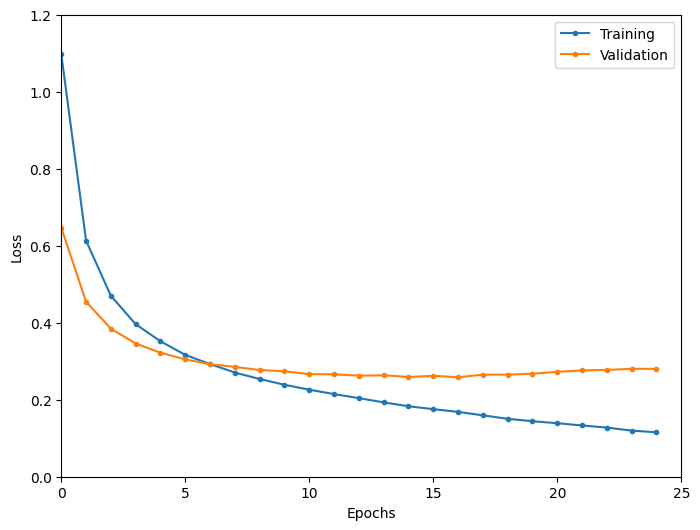

In [167]:
model = Classifier(
    max_length, len(vocab) + 1, 100, 4
)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
EPOCHS = 25

history = {
    'loss': np.zeros((EPOCHS, 2)),
    'accuracy': np.zeros((EPOCHS, 2))
}

for epoch in tqdm(range(EPOCHS)):
    train_loss = 0
    train_acc = 0
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        preds = model(X)
        loss = criterion(preds, y)
        train_loss += loss.item()
        train_acc += (torch.sum(preds.argmax(dim=-1) == y) / 64)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= batch + 1
    train_acc /= batch + 1

    valid_loss = 0
    valid_acc = 0
    model.eval()
    for batch, (X, y) in enumerate(valid_dataloader):
        preds = model(X)
        loss = criterion(preds, y)
        valid_loss += loss.item()
        valid_acc += (torch.sum(preds.argmax(dim=-1) == y) / 64)

    valid_loss /= batch + 1
    valid_acc /= batch + 1

    history['loss'][epoch] = train_loss, valid_loss
    history['accuracy'][epoch] = train_acc.detach().numpy(), valid_acc.detach().numpy()
    print(f'Train Loss: {train_loss:0.5f} Valid Loss: {valid_loss:0.5f}')
    print(f'Train Accuracy: {train_acc * 100:0.2f} % Valid Accuracy: {valid_acc * 100:0.2f} %\n')

t_loss = history['loss'][:, 0]
v_loss = history['loss'][:, 1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t_loss, '.-', label='Training')
ax.plot(v_loss, '.-', label='Validation')
ax.set(
    xlabel='Epochs',
    ylabel='Loss',
    xlim=[0, EPOCHS],
    ylim=[0, 1.2]
)
ax.legend()
plt.show()

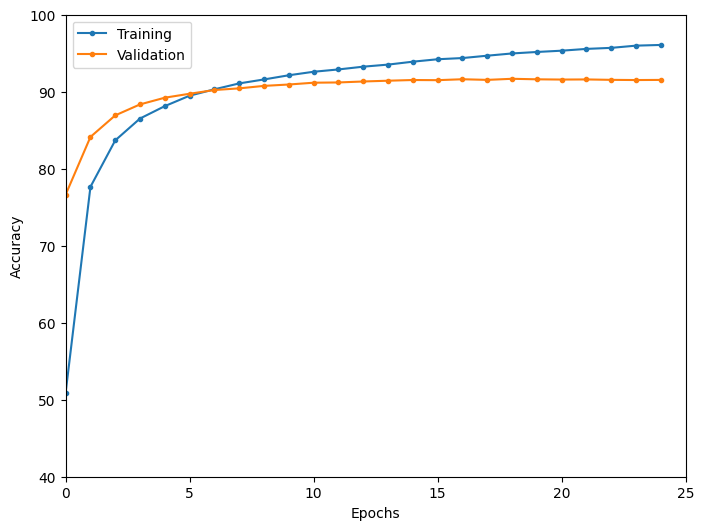

In [170]:
t_loss = history['accuracy'][:, 0]
v_loss = history['accuracy'][:, 1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t_loss * 100, '.-', label='Training')
ax.plot(v_loss * 100, '.-', label='Validation')
ax.set(
    xlabel='Epochs',
    ylabel='Accuracy',
    xlim=[0, EPOCHS],
    ylim=[40, 100]
)
ax.legend()
plt.show()

In [254]:
def classify(
        model: nn.Module, samples: list, encoder: dict,
        n_samples: int, batch_size=64, max_length: int=max_length,
    ) -> int:
    tensor = torch.zeros(size=(batch_size, max_length), dtype=torch.int32)
    for idx, token in enumerate(samples):
        for jdx, word in enumerate(token):
            tensor[idx, jdx] = encoder[word]
    labels = ['World', 'Sports', 'Business', 'Sci/Tech']
    with torch.no_grad():
       preds = model(tensor)
    preds = preds[:n_samples, :].argmax(dim=-1)
    for i in range(n_samples):
        print('Predicted Class:', labels[preds[i].item()])

In [255]:
text = 'Georgia mayor faces felony charges after investigators say he stashed alcohol in ditch for prisoners'
processed = pipeline(text)
print(text)
classify(model, [processed], encoder, n_samples=1)

Georgia mayor faces felony charges after investigators say he stashed alcohol in ditch for prisoners
Predicted Class: World


In [258]:
text = 'A child was reported missing. A TV news helicopter crew spotted him on the roof playing skip'
processed = pipeline(text)
print(text)
classify(model, [processed], encoder, n_samples=1)

A child was reported missing. A TV news helicopter crew spotted him on the roof playing skip
Predicted Class: World


In [259]:
text = 'Wall Street gains slightly, with weakness in banks and energy weighing'
processed = pipeline(text)
print(text)
classify(model, [processed], encoder, n_samples=1)

Wall Street gains slightly, with weakness in banks and energy weighing
Predicted Class: Business
